# Pre-processing

In [1]:
import pandas as pd
import pathlib
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#import utilities
import sys
sys.path.append('src/')
import utils as utils

#from sklearn.model_selection import train_test_split

In [17]:
from comet_ml import Experiment

In [2]:
# Import the data
metadata = pd.read_csv('gwhd_2021/metadata_dataset.csv', sep=';')
# Update metadata['name'] to metadata['domain'] to match full column name
metadata.rename(columns = {"name": "domain"}, inplace=True)

In [3]:
train = pd.read_csv('gwhd_2021/competition_train.csv')

In [4]:
train_df = train.merge(metadata, on='domain')

In [5]:
train_df = utils.preprocess_df(train_df)

In [6]:
train_df.head()

,image_name,BoxesString,domain,country,location,development_stage,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax
0,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[99, 692, 160, 764]",Arvalis_1,France,Gréoux,Post-flowering,99.0,692.0,160.0,764.0
1,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[641, 27, 697, 115]",Arvalis_1,France,Gréoux,Post-flowering,641.0,27.0,697.0,115.0
2,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[935, 978, 1012, 1020]",Arvalis_1,France,Gréoux,Post-flowering,935.0,978.0,1012.0,1020.0
3,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[377, 834, 463, 890]",Arvalis_1,France,Gréoux,Post-flowering,377.0,834.0,463.0,890.0
4,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[654, 797, 696, 837]",Arvalis_1,France,Gréoux,Post-flowering,654.0,797.0,696.0,837.0


First off, let's address the class imbalances of development stage. 

## Balancing class distribution

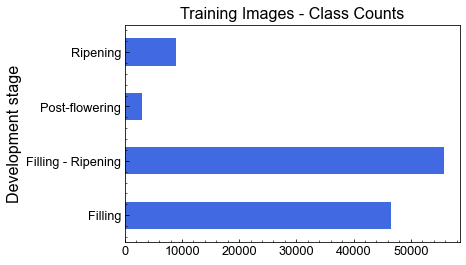

In [7]:
utils.set_plot(16)
train_df.groupby('development_stage').count().plot.barh(title='Training Images - Class Counts', 
                                                        legend=False, color='royalblue', 
                                                        xlabel="Development stage")
plt.show()

In [8]:
# To use the balanced_df function, we will need a numeric label representation
label_dict = {'Ripening': 0, 'Post-flowering': 1, 'Filling - Ripening': 2, 'Filling': 3}

train_df['label'] = train_df['development_stage'].copy()
train_df['label'].replace(label_dict, inplace=True)

In [9]:
train_df

,image_name,BoxesString,domain,country,location,development_stage,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,label
0,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[99, 692, 160, 764]",Arvalis_1,France,Gréoux,Post-flowering,99.0,692.0,160.0,764.0,1
1,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[641, 27, 697, 115]",Arvalis_1,France,Gréoux,Post-flowering,641.0,27.0,697.0,115.0,1
2,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[935, 978, 1012, 1020]",Arvalis_1,France,Gréoux,Post-flowering,935.0,978.0,1012.0,1020.0,1
3,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[377, 834, 463, 890]",Arvalis_1,France,Gréoux,Post-flowering,377.0,834.0,463.0,890.0,1
4,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[654, 797, 696, 837]",Arvalis_1,France,Gréoux,Post-flowering,654.0,797.0,696.0,837.0,1
...,...,...,...,...,...,...,...,...,...,...,...
114132,de85de89b3969fc6eb97d0c83299ad725a52595bde4533...,"[640, 1000, 700, 1024]",ULiège-GxABT_1,Belgium,Gembloux,Ripening,640.0,1000.0,700.0,1024.0,0
114133,de85de89b3969fc6eb97d0c83299ad725a52595bde4533...,"[365, 988, 450, 1024]",ULiège-GxABT_1,Belgium,Gembloux,Ripening,365.0,988.0,450.0,1024.0,0
114134,de85de89b3969fc6eb97d0c83299ad725a52595bde4533...,"[534, 982, 635, 1023]",ULiège-GxABT_1,Belgium,Gembloux,Ripening,534.0,982.0,635.0,1023.0,0
114135,de85de89b3969fc6eb97d0c83299ad725a52595bde4533...,"[608, 921, 820, 999]",ULiège-GxABT_1,Belgium,Gembloux,Ripening,608.0,921.0,820.0,999.0,0


In [10]:
# The data is clearly quite imbalanced. 
# We will want to resample the data to have balanced classes.
balanced_df = utils.balance_df(train_df, class_size=10000)

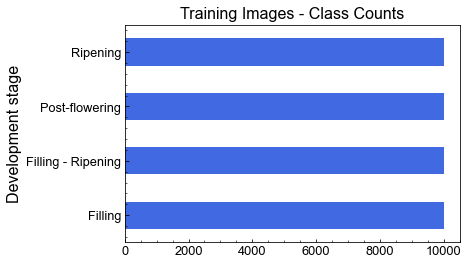

In [13]:
balanced_df.groupby('development_stage').count().plot.barh(title='Training Images - Class Counts', 
                                                        legend=False, color='royalblue', 
                                                        xlabel="Development stage")
plt.show()